In [161]:
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, MinMaxScaler
from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p

In [162]:
# Open all the files
train = pd.read_csv("./data/House price prediction/train.csv")
test = pd.read_csv("./data/House price prediction/test.csv")

In [163]:
# Check the missing values
def missing(df):
 data = pd.DataFrame(df)
 df_cols = list(pd.DataFrame(data))

 dict_x = {}
 for i in range(0, len(df_cols)):
  dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100, 2)})

 m_sorted = sorted(dict_x.items(), key=lambda x: x[1], reverse=True)
 
 return m_sorted[0:10]

print(missing(train))

[('PoolQC', 99.52), ('MiscFeature', 96.3), ('Alley', 93.77), ('Fence', 80.75), ('FireplaceQu', 47.26), ('LotFrontage', 17.74), ('GarageType', 5.55), ('GarageYrBlt', 5.55), ('GarageFinish', 5.55), ('GarageQual', 5.55)]


In [164]:
def clean_data(df):
 df = df.drop(["PoolQC", "MiscFeature", "Alley", "Fence"], axis = 1)

 return df

In [165]:
def handle_missing(features):
 features['Functional'] = features['Functional'].fillna("Typ")
 features['Electrical'] = features['Electrical'].fillna("SBrkr")
 features['KitchenQual'] = features['KitchenQual'].fillna("TA")

 features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
 features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
 features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

 features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

 #Check MSZoning

 features['PoolQC'] = features['PoolQC'].fillna("None")
 for col in ("GarageYrBlt", "GarageArea", "GarageCars"):
  features[col] = features[col].fillna(0)
 for col in ("GarageType", "GarageFinish", "GarageQual", "GarageCond"):
  features[col] = features[col].fillna("None")
 for col in ("BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"):
  features[col] = features[col].fillna("None")

 features['LotFrontage'] = features.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

 objects = []

 for i in features.columns:
  if features[i].dtype == object:
   objects.append(i)
 
 features.update(features[objects].fillna("None"))

 num_dtypes = ["float64", "int64", "float32", 'int32', 'float16', 'int16']

 numerics = []
 for i in features.columns:
  if features[i].dtype in num_dtypes:
   numerics.append(i)
 
 features.update(features[numerics].fillna(0))

 return features

In [166]:
train = handle_missing(train)
test = handle_missing(test)

train = clean_data(train)
test = clean_data(test)

c:\Users\Administrator\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

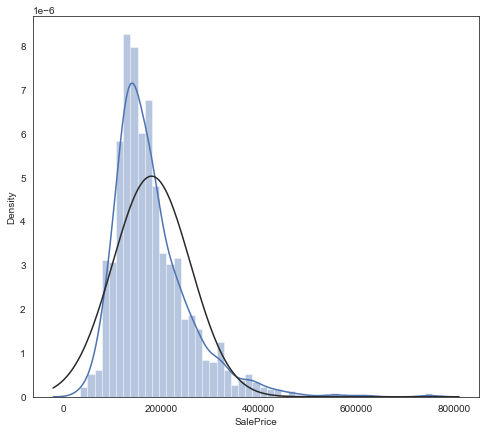

In [167]:
# Check the distribution of the data

sns.set_color_codes(palette="deep")
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(train["SalePrice"], fit = norm, color='b')


c:\Users\Administrator\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


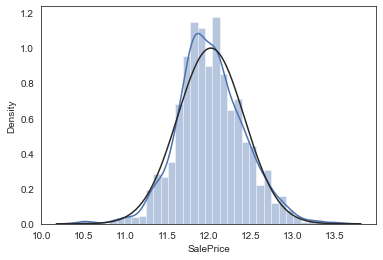

In [168]:
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'], fit=norm, color='b')

# drop the "Id" column
train = train.drop("Id", axis=1)
test = test.drop("Id", axis=1)

In [169]:
numeric_types = ["int16", "float16", "int32", "float32", "int64", "float64"]
numeric_values = []

for i in train.columns:
 if train[i].dtype in numeric_types:
  numeric_values.append(i)

In [170]:
# lets find the skewness of all the features we have
features_skewness = train[numeric_values].apply(lambda x: skew(x)).sort_values(ascending=False)
features_skewness.head(15)

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.674865
OpenPorchSF       2.361912
LotFrontage       2.210685
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
dtype: float64

In [171]:
for i in numeric_values:
 train[i] = boxcox1p(train[i], boxcox_normmax(train[i] + 1))

c:\Users\Administrator\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\Users\Administrator\anaconda3\lib\site-packages\scipy\stats\stats.py:4053: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [172]:
features_skewness = train[numeric_values].apply(lambda x: skew(x)).sort_values(ascending=False)
features_skewness.head(len(features_skewness))

c:\Users\Administrator\anaconda3\lib\site-packages\scipy\stats\stats.py:955: RuntimeWarning: overflow encountered in square
  s = a_zero_mean**2
c:\Users\Administrator\anaconda3\lib\site-packages\scipy\stats\stats.py:959: RuntimeWarning: overflow encountered in square
  s = s**2
C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\Administrator\anaconda3\lib\site-packages\scipy\stats\stats.py:961: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean


PoolArea         14.476284
3SsnPorch         7.744137
LowQualFinSF      7.392523
MiscVal           5.199813
KitchenAbvGr      3.953381
BsmtHalfBath      3.925130
ScreenPorch       3.328194
BsmtFinSF2        2.645006
EnclosedPorch     2.285796
MasVnrArea        0.953281
2ndFlrSF          0.883107
WoodDeckSF        0.776782
HalfBath          0.711553
OpenPorchSF       0.624656
BsmtFullBath      0.590504
Fireplaces        0.514500
TotalBsmtSF       0.452285
MSSubClass        0.431145
BsmtFinSF1        0.381851
OverallCond       0.335371
GarageArea        0.197671
YrSold            0.100009
OverallQual       0.062167
BsmtUnfSF         0.053031
TotRmsAbvGrd      0.040872
SalePrice         0.037411
FullBath          0.034347
BedroomAbvGr      0.024323
GrLivArea         0.005867
YearRemodAdd      0.000000
1stFlrSF         -0.006599
LotFrontage      -0.010815
MoSold           -0.019593
GarageCars       -0.087104
LotArea          -0.185294
YearBuilt        -0.247787
GarageYrBlt            NaN
d